# SLV Time Series

**Import all the relevant packages.** 

In [356]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### Data Cleaning/Wrangling

**Read into variables data from the dataset.**

In [357]:
slv = pd.read_csv('data/SLV.csv')

**Review data to ensure proper implementation.**

In [358]:
slv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-04-28,12.900,13.980,12.870,13.812,13.812,23432000
1,2006-05-01,13.920,14.179,13.750,13.870,13.870,14835000
2,2006-05-02,14.245,14.400,14.100,14.365,14.365,12511000
3,2006-05-03,14.450,14.464,13.413,13.925,13.925,15141000
4,2006-05-04,13.950,14.287,13.680,14.000,14.000,11075000


**Check that data conforms to expectations.**

In [359]:
slv.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3.890000e+03
mean,18.866024,19.036925,18.673275,18.859959,18.859959,1.391545e+07
std,6.560916,6.642149,6.456286,6.559651,6.559651,1.748706e+07
min,8.710000,9.050000,8.450000,8.850000,8.850000,1.039000e+06
25%,14.390000,14.510000,14.300000,14.400000,14.400000,5.673300e+06
50%,16.540001,16.660000,16.389999,16.540001,16.540001,8.682400e+06
75%,21.627499,21.850000,21.420000,21.637499,21.637499,1.573058e+07
max,47.619999,48.349998,46.549999,47.259998,47.259998,2.954000e+08


**Format date as *Datetime* and set date as index.**

In [360]:
fmt = '%Y-%m-%d' 
slv['Date']=pd.to_datetime(slv['Date'],format=fmt)
slv.set_index(pd.DatetimeIndex(slv['Date']),inplace=True)

**Check for null values.**

In [361]:
slv.isnull().values.any()

False

**Verify redundant column and remove it**

In [362]:
slv[slv['Close']!=slv['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,


**Add column representing trading day**

In [363]:
slv.drop(['Adj Close'],axis=1,inplace=True)
slv['Day'] = np.arange(1,len(slv)+1)
slv = slv[['Day','Open','Low','High','Close','Volume']]
slv.head()

,Day,Open,Low,High,Close,Volume
Date,,,,,,
2006-04-28,1,12.900,12.870,13.980,13.812,23432000
2006-05-01,2,13.920,13.750,14.179,13.870,14835000
2006-05-02,3,14.245,14.100,14.400,14.365,12511000
2006-05-03,4,14.450,13.413,14.464,13.925,15141000
2006-05-04,5,13.950,13.680,14.287,14.000,11075000


### Exploratory Data Analysis

**Graph the data.**

In [364]:
slv.tail()

,Day,Open,Low,High,Close,Volume
Date,,,,,,
2021-10-04,3886,20.760000,20.700001,21.030001,20.980000,25183900
2021-10-05,3887,20.840000,20.709999,20.980000,20.920000,21548900
2021-10-06,3888,20.750000,20.650000,21.010000,20.959999,22553300
2021-10-07,3889,20.790001,20.780001,21.100000,20.900000,19484300
2021-10-08,3890,21.389999,20.940001,21.440001,20.950001,33290400


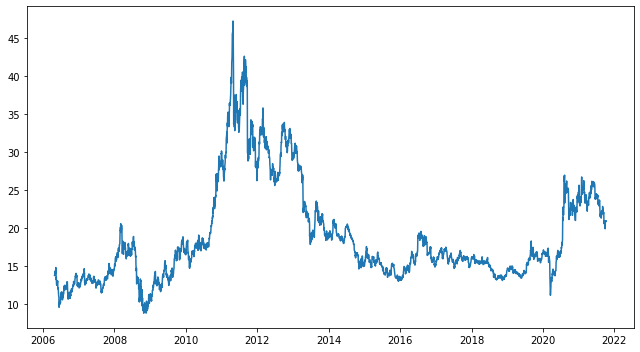

In [365]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
ax.plot(slv.index,slv['Close'])
fig.tight_layout()

**Compare data with GLD (Gold) and SPY (Large Cap Index)**

In [366]:
# Read in comparison data
gld = pd.read_csv('data/GLD.csv')
spy = pd.read_csv('data/SPY.csv')
fmt = '%Y-%m-%d' 
gld['Date']=pd.to_datetime(gld['Date'],format=fmt)
gld.set_index(pd.DatetimeIndex(gld['Date']),inplace=True)
spy['Date']=pd.to_datetime(spy['Date'],format=fmt)
spy.set_index(pd.DatetimeIndex(spy['Date']),inplace=True)

# Calculate percent change from beginning of dataset
slv0 = slv.loc['2006-04-28','Close']
gld0 = gld.loc['2006-04-28','Close']
spy0 = spy.loc['2006-04-28','Close']
silver = (slv['Close'] - slv0)/slv0
gold = (gld['Close'] - gld0)/gld0
market = (spy['Close'] - spy0)/spy0

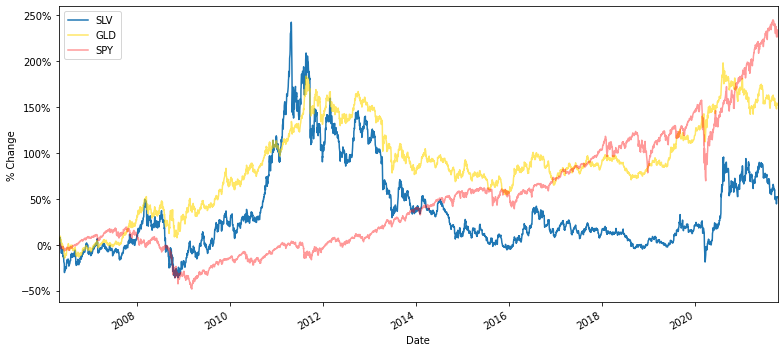

In [367]:
import matplotlib.ticker as tick
fig, ax = plt.subplots(1,1,figsize=(11,5))
xmin, xmax = datetime.date(2006,4,28), datetime.date(2021,10,8)
silver.plot(label='SLV',xlim=[xmin,xmax])
gold.plot(color='gold',alpha=0.6,label='GLD',xlim=[xmin,xmax])
market.plot(color='red',alpha=0.4,label='SPY',xlim=[xmin,xmax])
ax.yaxis.set_major_formatter(tick.PercentFormatter(1,decimals=0))
ax.legend(loc='best')
ax.set_ylabel('% Change')
fig.tight_layout()

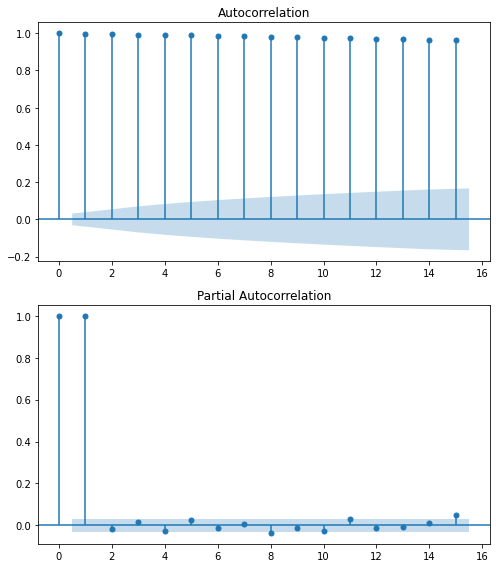

In [368]:
data = slv['Close']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,8))
plot_acf(data,alpha=0.05,lags=15, ax=ax1)
plot_pacf(data,alpha=0.05,lags=15, ax=ax2)
fig.tight_layout()

**SLV exhibits very slight fall-off in autocorrelation on a daily basis. However, in the partial
autocorrelation plot (PACF), only lag 1 shows a significant correlation.**

**Test for stationarity**

In [369]:
from statsmodels.tsa.stattools import adfuller,kpss
adf_result = adfuller(slv['Close'])
print(f'Augmented Dickey-Fuller test p-value: {adf_result[1]}')

Augmented Dickey-Fuller test p-value: 0.2724331971404951


**SLV data is not stationary**

**But removing the trend and seasonal components does stationarize the data.**

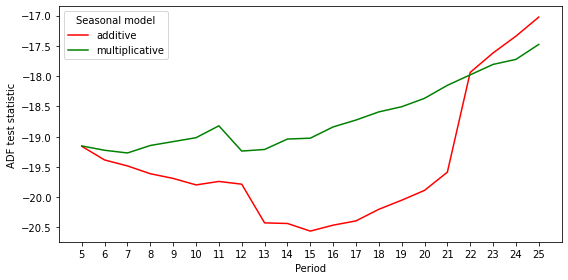

In [370]:
models = ['additive','multiplicative']
#periods=[5,21,252]
periods = np.arange(5,26)
adf = pd.DataFrame(columns=['additive','multiplicative'],index=periods)
for model in models:
    for period in periods:
        deco = sm.tsa.seasonal_decompose(slv['Close'],model=model,period=period)
        trend = deco.trend
        seasonal = deco.seasonal
        residual = deco.resid
        residual.dropna(inplace=True)
        adf.loc[period,model] = adfuller(residual)[0]
fig = plt.figure(figsize=(8,4))
adf.additive.plot(color='red',label='additive')
plt.xticks(periods)
plt.xlabel('Period')
plt.ylabel('ADF test statistic')
adf.multiplicative.plot(color='green',label='multiplicative')
plt.legend(title='Seasonal model')
fig.tight_layout()

Augmented Dickey-Fuller test results: (-20.559630164706263, 0.0)


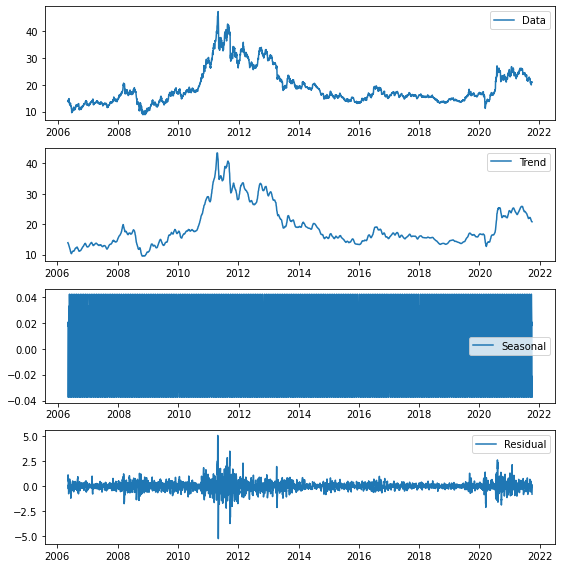

In [371]:
deco = sm.tsa.seasonal_decompose(slv['Close'],model='additive',period=15)
trend = deco.trend
seasonal = deco.seasonal
residual = deco.resid

fig = plt.figure(figsize=(8,8))
plt.subplot(411)
plt.plot(slv['Close'],label = 'Data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
fig.tight_layout()
residual.dropna(inplace=True)
adf_result = adfuller(residual)
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')

**For comparison, taking the first difference produces well-stationarized data but higher ADF statistic**

In [372]:
slv_dif1 = slv.diff().dropna()
adf_result = adfuller(slv_dif1['Close'])
print(f'Augmented Dickey-Fuller test statistic: {adf_result[0]}')
print(f'Augmented Dickey-Fuller test p-value: {adf_result[1]}')

Augmented Dickey-Fuller test statistic: -12.694823634837377
Augmented Dickey-Fuller test p-value: 1.111955283563771e-23


**KPSS results can't reject null hypothesis of trend-stationarity, confirming ADF result.**

In [373]:
kpss_result = kpss(residual,nlags='auto')
print(f'Kwiatkowski-Phillips-Schmidt-Shin test results: {kpss_result[0],kpss_result[1]}')

Kwiatkowski-Phillips-Schmidt-Shin test results: (0.005733855968598033, 0.1)


/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**15-day seasonality**

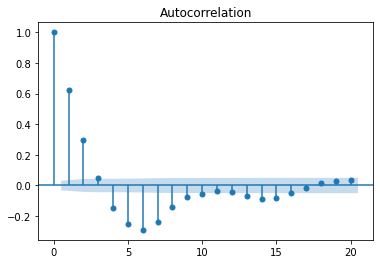

In [374]:
data = residual
plot_acf(data,alpha=0.05,lags=20)
plt.show()

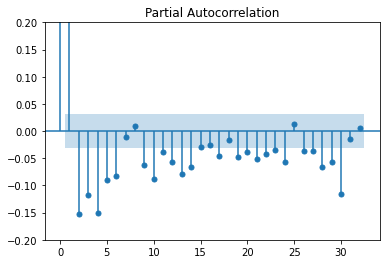

In [375]:
data = residual
plot_pacf(data,alpha=0.05,lags=32)
plt.ylim([-0.2,0.2])
plt.show()

**Resample to weekly data to reduce noise. Change period to 3 weeks (corresponding to 15 trading days).**

In [376]:
weekly=slv.resample('W').last()

Augmented Dickey-Fuller test results: (-20.559630164706263, 0.0)


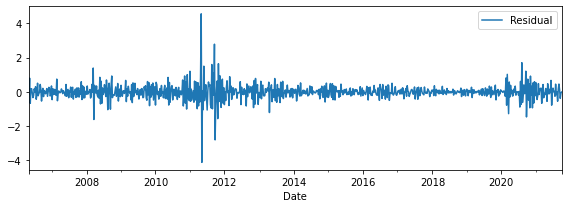

In [377]:
deco = sm.tsa.seasonal_decompose(weekly['Close'],model='additive',period=3)
wk3_trend = deco.trend
wk3_seasonal = deco.seasonal
wk3_residual = deco.resid
wk3_residual.dropna(inplace=True)
fig = plt.figure(figsize=(8,3))
wk3_residual.plot(label = 'Residual')
plt.legend(loc = 'best')
fig.tight_layout()
adf_result = adfuller(residual)
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')

### Scenario 1: Removing trend/seasonality (Weekly)

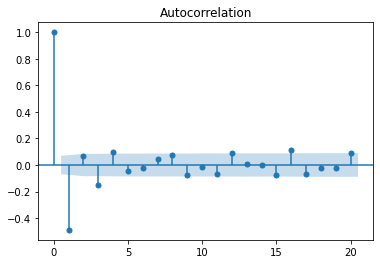

In [378]:
data = wk3_residual
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data,alpha=0.05,lags=20)
plt.show()

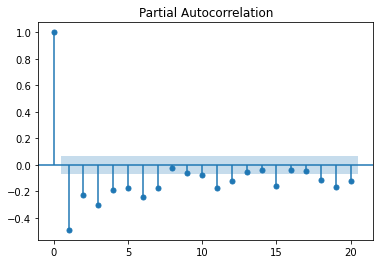

In [379]:
data = wk3_residual
plot_pacf(data,alpha=0.05,lags=20)
plt.show()

#### Summary ####
- **Significant negative correlations at lags 1 & 3 in ACF plot**
- **Lag 1 shows a larger negative correlation in the PACF plot, but other lags show significant correlations**
- **Thus, order classification is not clear through this method**


### Scenario 2: Differencing (Daily)

**There is no significant correlation between the first-differenced value and the lags, until possibly
lag 14 or 15.**

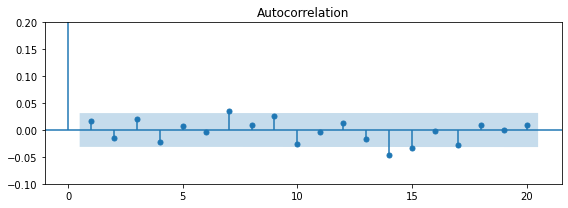

In [380]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = slv.diff().dropna()['Close']
plot_acf(data,alpha=0.05,lags=20, ax=ax)
ax.set_ylim(-0.1,0.2)
fig.tight_layout()

**We try the weekly sample.**

Augmented Dickey-Fuller test results: (-5.809907443404273, 4.426280382567062e-07)


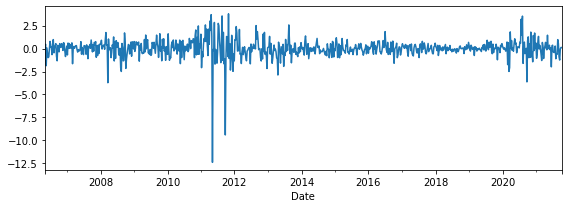

In [381]:
fig = plt.figure(figsize=(8,3))
wk_dif1 = weekly.diff().dropna()
adf_result = adfuller(wk_dif1['Close'])
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')
wk_dif1.Close.plot()
fig.tight_layout()

**Small but significant correlation at lag 3 for both ACF & PACF.**

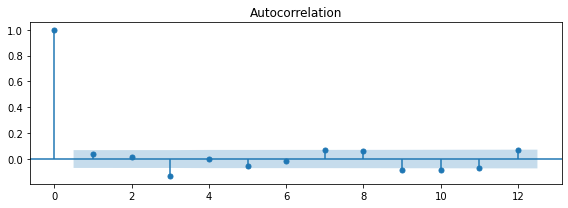

In [382]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = wk_dif1['Close']
plot_acf(data,alpha=0.05,lags=12, ax=ax)
fig.tight_layout()

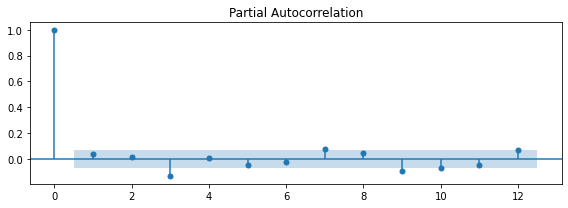

In [383]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = wk_dif1['Close']
plot_pacf(data,alpha=0.05,lags=12, ax=ax)
fig.tight_layout()

#### Summary ####
- **Significant correlation at lag 3 in both ACF and PACF plots**
- **PACF plot showing similar pattern as ACF plot**
- **Again, a model classification from the plot is not obvious**